# DDM

In [1]:
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset,DataLoader
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
sys.path.append('C:/Users/Raphael/OneDrive/备份/桌面/大学生活和学习/教材/深度学习/Generative-Deep-Learning')
from utiles import display
device =  torch.device('cuda')

In [2]:
IMAGE_SIZE = 64
BATCH_SIZE = 64
DATASET_REPETITIONS = 5
LOAD_MODEL = False

NOISE_EMBEDDING_SIZE = 32
PLOT_DIFFUSION_STEPS = 20

# optimization
EMA = 0.999
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4
EPOCHS = 50

TRAIN_DATA_PATH = "C:/Users/Raphael/OneDrive/备份/桌面/大学生活和学习/教材/深度学习/Generative-Deep-Learning/datas/flowers dataset/dataset/train"

1. 加载数据集

In [3]:
class FLowerDataset(Dataset):
    def __init__(self, data_dir, transform, repetitions):
        self.data = datasets.ImageFolder(data_dir, transform=transform)
        self.repetitions = repetitions

    def __getitem__(self, index):
        orig_index = index % len(self.data)
        # rep_index = index // len(self.data)
        img, label = self.data[orig_index]
        return img, label

    def __len__(self):
        return len(self.data) * self.repetitions

train_data = FLowerDataset(
    TRAIN_DATA_PATH,
    transform=transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
    ]),
    repetitions=DATASET_REPETITIONS
)
train_loader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
)

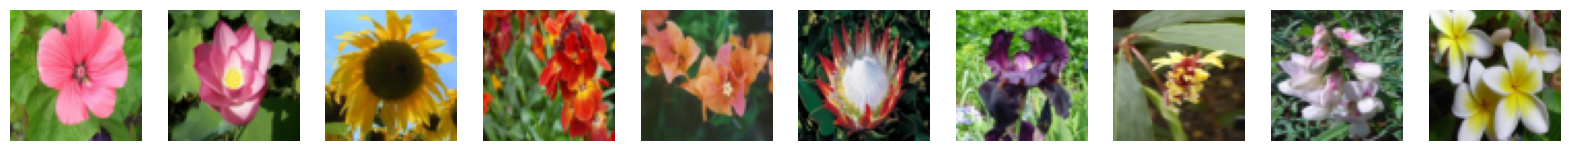

In [4]:
train_sample, _ = next(iter(train_loader))
images = np.transpose(torch.squeeze(train_sample[:10]).cpu().numpy(),(0,2,3,1))
display(images)

2. 扩散方案


In [5]:
def linear_diffusion_schedule(diffusion_times):
    min_rate = 0.0001
    max_rate = 0.02
    betas = min_rate + diffusion_times * (max_rate - min_rate)
    alphas = 1 - betas
    alpha_bars = torch.cumprod(alphas, dim=0)
    signal_rates = torch.sqrt(alpha_bars)
    noise_rates = torch.sqrt(1 - alpha_bars)
    return noise_rates, signal_rates


In [6]:
def cosine_diffusion_schedule(diffusion_times):
    signal_rates = torch.cos(diffusion_times * torch.pi / 2)
    noise_rates = torch.sin(diffusion_times * torch.pi / 2)
    return noise_rates, signal_rates


In [7]:
def offset_cosine_diffusion_schedule(diffusion_times):
    min_signal_rate = 0.02
    max_signal_rate = 0.95
    start_angle = torch.acos(torch.tensor(max_signal_rate))
    end_angle = torch.acos(torch.tensor(min_signal_rate))
    diffusion_angles = start_angle + diffusion_times * (end_angle - start_angle)
    signal_rates = torch.cos(diffusion_angles)
    noise_rates = torch.sin(diffusion_angles)
    return noise_rates, signal_rates

3. 建立模型

- 正弦编码器

In [23]:
def sinusoidal_embedding(x):
    frequencies = torch.exp(
        torch.linspace(
            torch.log(torch.tensor(1.0)),
            torch.log(torch.tensor(1000.0)),
            NOISE_EMBEDDING_SIZE // 2,
        )
    ).to(x.device)
    angular_speeds = 2.0 * torch.pi * frequencies
    embeddings = torch.cat(
        [torch.sin(angular_speeds * x), torch.cos(angular_speeds * x)]
    )
    return embeddings

- 残差块 

In [9]:
class ResidualBlock(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(ResidualBlock,self).__init__()
        self.conv1 = nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1)
        self.conv2 = nn.Conv2d(out_channels,out_channels,kernel_size=3,padding=1)
        self.conv_residual = nn.Conv2d(in_channels,out_channels,kernel_size=1)
        self.bn = nn.BatchNorm2d(in_channels,affine=False)
        self.width = out_channels

    def forward(self,x):
        input_width = x.shape[1]
        if input_width == self.width:
            residual = x
        else:
            residual = self.conv_residual(x)
        x = self.bn(x)
        x = F.silu(self.conv1(x))
        x = self.conv2(x)
        x = x+residual
        return x


In [10]:
class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels, block_depth):
        super(DownBlock, self).__init__()
        self.residual1 = ResidualBlock(in_channels, out_channels)
        self.residuals = nn.ModuleList([ResidualBlock(out_channels, out_channels) for _ in range(block_depth-1)])
        self.pool = nn.AvgPool2d(kernel_size=2)

    def forward(self, x):
        x, skips = x
        x = self.residual1(x)
        skips.append(x)
        for block in self.residuals:
            x = block(x)
            skips.append(x)
        x = self.pool(x)
        return x, skips


class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, skips_channels, block_depth):
        super(UpBlock, self).__init__()
        self.residual1 = ResidualBlock(in_channels+skips_channels, out_channels)
        self.residuals = nn.ModuleList([ResidualBlock(out_channels+skips_channels, out_channels) for _ in range(block_depth-1)])
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self, x):
        x, skips = x
        x = self.up(x)
        x = torch.cat([x, skips.pop()], dim=1)
        x = self.residual1(x)
        for block in self.residuals:
            x = torch.cat([x, skips.pop()], dim=1)
            x = block(x)
        return x, skips

In [13]:
class UNet(nn.Module):
    def __init__(self, image_size):
        super(UNet, self).__init__()
        self.image_size = image_size
        # Noisy Image经过的第一个卷积层
        self.conv1 = nn.Conv2d(3, 32, kernel_size=1)
        # Noise variance 经过的两个层
        self.embedding = sinusoidal_embedding
        self.upsample = nn.Upsample(size=self.image_size, mode='nearest')
        # 三个DownBlock
        self.down1 = DownBlock(64, 32, block_depth=2)
        self.down2 = DownBlock(32, 64, block_depth=2)
        self.down3 = DownBlock(64, 96, block_depth=2)
        # 两个ResidualBlock
        self.res1 = ResidualBlock(96, 128)
        self.res2 = ResidualBlock(128, 128)
        # 三个UpBlock
        self.up1 = UpBlock(128, 96, 96, block_depth=2)
        self.up2 = UpBlock(96, 64, 64, block_depth=2)
        self.up3 = UpBlock(64, 32, 32, block_depth=2)
        # 最后一个卷积层
        self.conv2 = nn.Conv2d(32, 3, kernel_size=1)

    def forward(self, x):
        noisy_images, noise_variances = x
        x = self.conv1(noisy_images)
        noise_embedding = self.embedding(noise_variances)
        noise_embedding = F.interpolate(noise_embedding)
        x = torch.cat([x, noise_embedding], dim=1)
        skips = []
        x, skips = self.down1([x,skips])
        x, skips = self.down2([x,skips])
        x, skips = self.down3([x,skips])
        x = self.res1(x)
        x = self.res2(x)
        x, skips = self.up1([x,skips])
        x, skips = self.up2([x,skips])
        x, skips = self.up3([x,skips])
        x = self.conv2(x)
        return x

In [25]:
unet = UNet(IMAGE_SIZE).to(device)
x = torch.randn(16, 3, 40, 40).to(device)  # Ensure the input tensor is on GPU
y = torch.randn(1).to(device)  # Ensure the weight tensor is on GPU
unet([x,y])

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 3)

In [24]:
import torch.onnx
import netron

modelData = "unet.onnx"
torch.onnx.export(unet, [x,y], modelData)
netron.start(modelData)

C:\Users\Raphael\AppData\Local\Temp\ipykernel_4244\2983266311.py:4: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  torch.log(torch.tensor(1.0)),
C:\Users\Raphael\AppData\Local\Temp\ipykernel_4244\2983266311.py:5: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  torch.log(torch.tensor(1000.0)),


============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 3)